# Прогнозирование спроса товаров собственного производства


### Описание задачи

Необходимо создать алгоритм прогноза спроса на 14 дней для товаров собственного производства. Гранулярность ТК-SKU-День.
 

### Описание данных

1. **sales_df_train.csv** –данные по продажам за скользящий год для обучения.

     * *st_id* – захэшированное id магазина;
     * *pr_sku_id* – захэшированное id товара;
     * *date* – дата;
     * *pr_sales_type_id* – флаг наличия промо;
     * *pr_sales_in_units* – число проданных товаров без признака промо;
     * *pr_promo_sales_in_units* – число проданных товаров с признаком промо;
     * *pr_sales_in_rub* – продажи без признака промо в РУБ;
     * *pr_promo_sales_in_rub* – продажи с признаком промо в РУБ;


2. **pr_df.csv** – данные по товарной иерархии.

    * *pr_group_id* – захэшированная группа товара;
    * *pr_cat_id* – захэшированная категория товара;
    * *pr_subcat_id* – захэшированная подкатегория товара;
    * *pr_sku_id* – захэшированное id товара;
    * *pr_uom_id* (маркер, обозначающий продаётся товар на вес или в ШТ).
    
    
    
3. **pr_st.csv** – данные по магазинам.

    * *st_id* – захэшированное id магазина;
    * *st_city_id* – захэшированное id города;
    * *st_division_code id* – захэшированное id дивизиона;
    * *st_type_format_id* – id формата магазина;
    * *st_type_loc_id* – id тип локации/окружения магазина;
    * *st_type_size_id* – id типа размера магазина;
    * *st_is_active* – флаг активного магазина на данный момент.



## Первичное ознакомление с данными

In [1]:
# Установка необходимых библиотек
!pip install statsmodels
!pip install catboost
!pip install lightgbm
!pip install xgboost 
!pip install --upgrade tables
!pip install blosc2~=2.0.0
!pip install pmdarima

In [2]:
# Импорт библиотек
import pandas as pd
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

warnings.filterwarnings('ignore')

In [3]:
# Построение графика изменения продаж товаров в штуках с рампределением по месяцам
def plot_cat_sales(data, name,  date, column1, column2, column3):
    
    df = data[data[column1] == name][[date, column2, column3]]
    df[date] = pd.to_datetime(df[date])
    df.set_index(date, inplace=True)
    pivot_table = df.pivot_table(index=df.index.month, columns=column2, values=column3, aggfunc='sum')

    plt.figure(figsize=(15, 5))
    
    sns.lineplot(data=pivot_table)
    plt.legend(loc='upper left')
    plt.xlabel('Месяц')
    plt.ylabel('Количество товара')
    plt.title(f'Изменение продаж товаров {name} группы по категориям по месяцам')
    plt.show()
    
    
# Установка даты в качестве индекса для создаваемых срезов таблицы при анализе
def set_date_index(input_df, col_name='date'):
    
    modified_df = input_df.copy()
    modified_df[col_name] = pd.to_datetime(modified_df[col_name])
    modified_df.set_index(col_name, inplace=True)

    return modified_df    


# Подсчет строк с отрицательными значениями в столбце
def neg_val(data, column):
    count = len(data[data[column] < 0])
    
    return count

# Расчет WAPE по скользящему среднему
def rolling_wape(y_true, y_pred):
    rolling_wape = np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))
    return rolling_wape

In [4]:
data_dir = 'C:/Users/tra88/Downloads/Лента/sp_sales_task'

df_train = os.path.join(data_dir, 'sales_df_train.csv')
df_pr = os.path.join(data_dir, 'pr_df.csv')
df_st_df = os.path.join(data_dir, 'st_df.csv')



train = pd.read_csv(df_train)
pr = pd.read_csv(df_pr)
st_df = pd.read_csv(df_st_df)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883015 entries, 0 to 883014
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   st_id                    883015 non-null  object 
 1   pr_sku_id                883015 non-null  object 
 2   date                     883015 non-null  object 
 3   pr_sales_type_id         883015 non-null  int64  
 4   pr_sales_in_units        883015 non-null  float64
 5   pr_promo_sales_in_units  883015 non-null  float64
 6   pr_sales_in_rub          883015 non-null  float64
 7   pr_promo_sales_in_rub    883015 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 53.9+ MB


In [6]:
pr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2050 entries, 0 to 2049
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pr_sku_id     2050 non-null   object
 1   pr_group_id   2050 non-null   object
 2   pr_cat_id     2050 non-null   object
 3   pr_subcat_id  2050 non-null   object
 4   pr_uom_id     2050 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 80.2+ KB


In [7]:
st_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   st_id              12 non-null     object
 1   st_city_id         12 non-null     object
 2   st_division_code   12 non-null     object
 3   st_type_format_id  12 non-null     int64 
 4   st_type_loc_id     12 non-null     int64 
 5   st_type_size_id    12 non-null     int64 
 6   st_is_active       12 non-null     int64 
dtypes: int64(4), object(3)
memory usage: 804.0+ bytes


In [8]:
train['date'] = pd.to_datetime(train['date'])

In [9]:
temp_df = pd.merge(train, pr, on='pr_sku_id')
df = pd.merge(temp_df, st_df, on='st_id')
del temp_df

In [10]:
# Создаем копию датафрейма
df_num = df.copy()

# Создаем словарь для хранения объектов LabelEncoder для каждого столбца
label_encoders = {}

for column_name in df.columns:
    if df[column_name].dtype == 'object':  # Проверяем, является ли столбец хэшированным
        le = LabelEncoder()
        df_num[column_name] = le.fit_transform(df[column_name])
        label_encoders[column_name] = le

In [11]:
df_num.describe()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active
count,883015.000000,883015.000000,883015,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000,883015.000000
mean,6.533965,986.529361,2023-01-25 18:19:37.852697856,0.406486,5.037956,2.230010,596.705181,294.766561,6.187769,19.021626,83.996075,6.751821,3.719790,1.873242,1.096438,1.206916,11.464332,0.999174
min,0.000000,0.000000,2022-08-01 00:00:00,0.000000,-39.000000,-39.000000,-3373.000000,-3373.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,8.000000,0.000000
25%,4.000000,515.000000,2022-10-29 00:00:00,0.000000,1.000000,0.000000,98.000000,0.000000,5.000000,4.000000,41.000000,1.000000,2.000000,0.000000,1.000000,1.000000,8.000000,1.000000
50%,7.000000,905.000000,2023-01-27 00:00:00,0.000000,2.000000,0.000000,224.000000,0.000000,6.000000,17.000000,89.000000,1.000000,3.000000,2.000000,1.000000,1.000000,12.000000,1.000000
75%,10.000000,1502.000000,2023-04-25 00:00:00,1.000000,4.000000,1.000000,540.000000,127.000000,8.000000,28.000000,132.000000,17.000000,5.000000,4.000000,1.000000,1.000000,12.000000,1.000000
max,11.000000,1990.000000,2023-07-18 00:00:00,1.000000,2348.000000,2348.000000,183265.000000,183265.000000,8.000000,42.000000,166.000000,17.000000,6.000000,5.000000,4.000000,3.000000,32.000000,1.000000
std,3.552645,572.384504,NaN,0.491178,13.402984,11.063288,1577.366179,1402.764168,1.885313,12.909207,48.320331,7.677614,1.719405,1.618767,0.415505,0.438867,4.509462,0.028721


In [12]:
# Процент продаж с нулевым количеством проданных товаров.
len(df_num.query('pr_sales_in_units == 0')) / len(df_num) *100

7.535885573857749

In [13]:
# Подсчет строк в столбцах с отрицательным значением
negative_column = ['pr_sales_in_units', 'pr_promo_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_rub']

for col in negative_column:
    print(f'Количество строк с отрицательным значением в столбце {col}:', neg_val(df_num, col))

Количество строк с отрицательным значением в столбце pr_sales_in_units: 71
Количество строк с отрицательным значением в столбце pr_promo_sales_in_units: 35
Количество строк с отрицательным значением в столбце pr_sales_in_rub: 78
Количество строк с отрицательным значением в столбце pr_promo_sales_in_rub: 36


# EDA 

In [14]:
# Создание списка категориальных признаков
cat_cols = ['st_id', 'pr_sales_type_id', 'pr_group_id', 'pr_cat_id', 
            'pr_uom_id', 'st_city_id', 'st_division_code',
            'st_type_format_id', 'st_type_loc_id', 'st_type_size_id',
            'st_is_active']

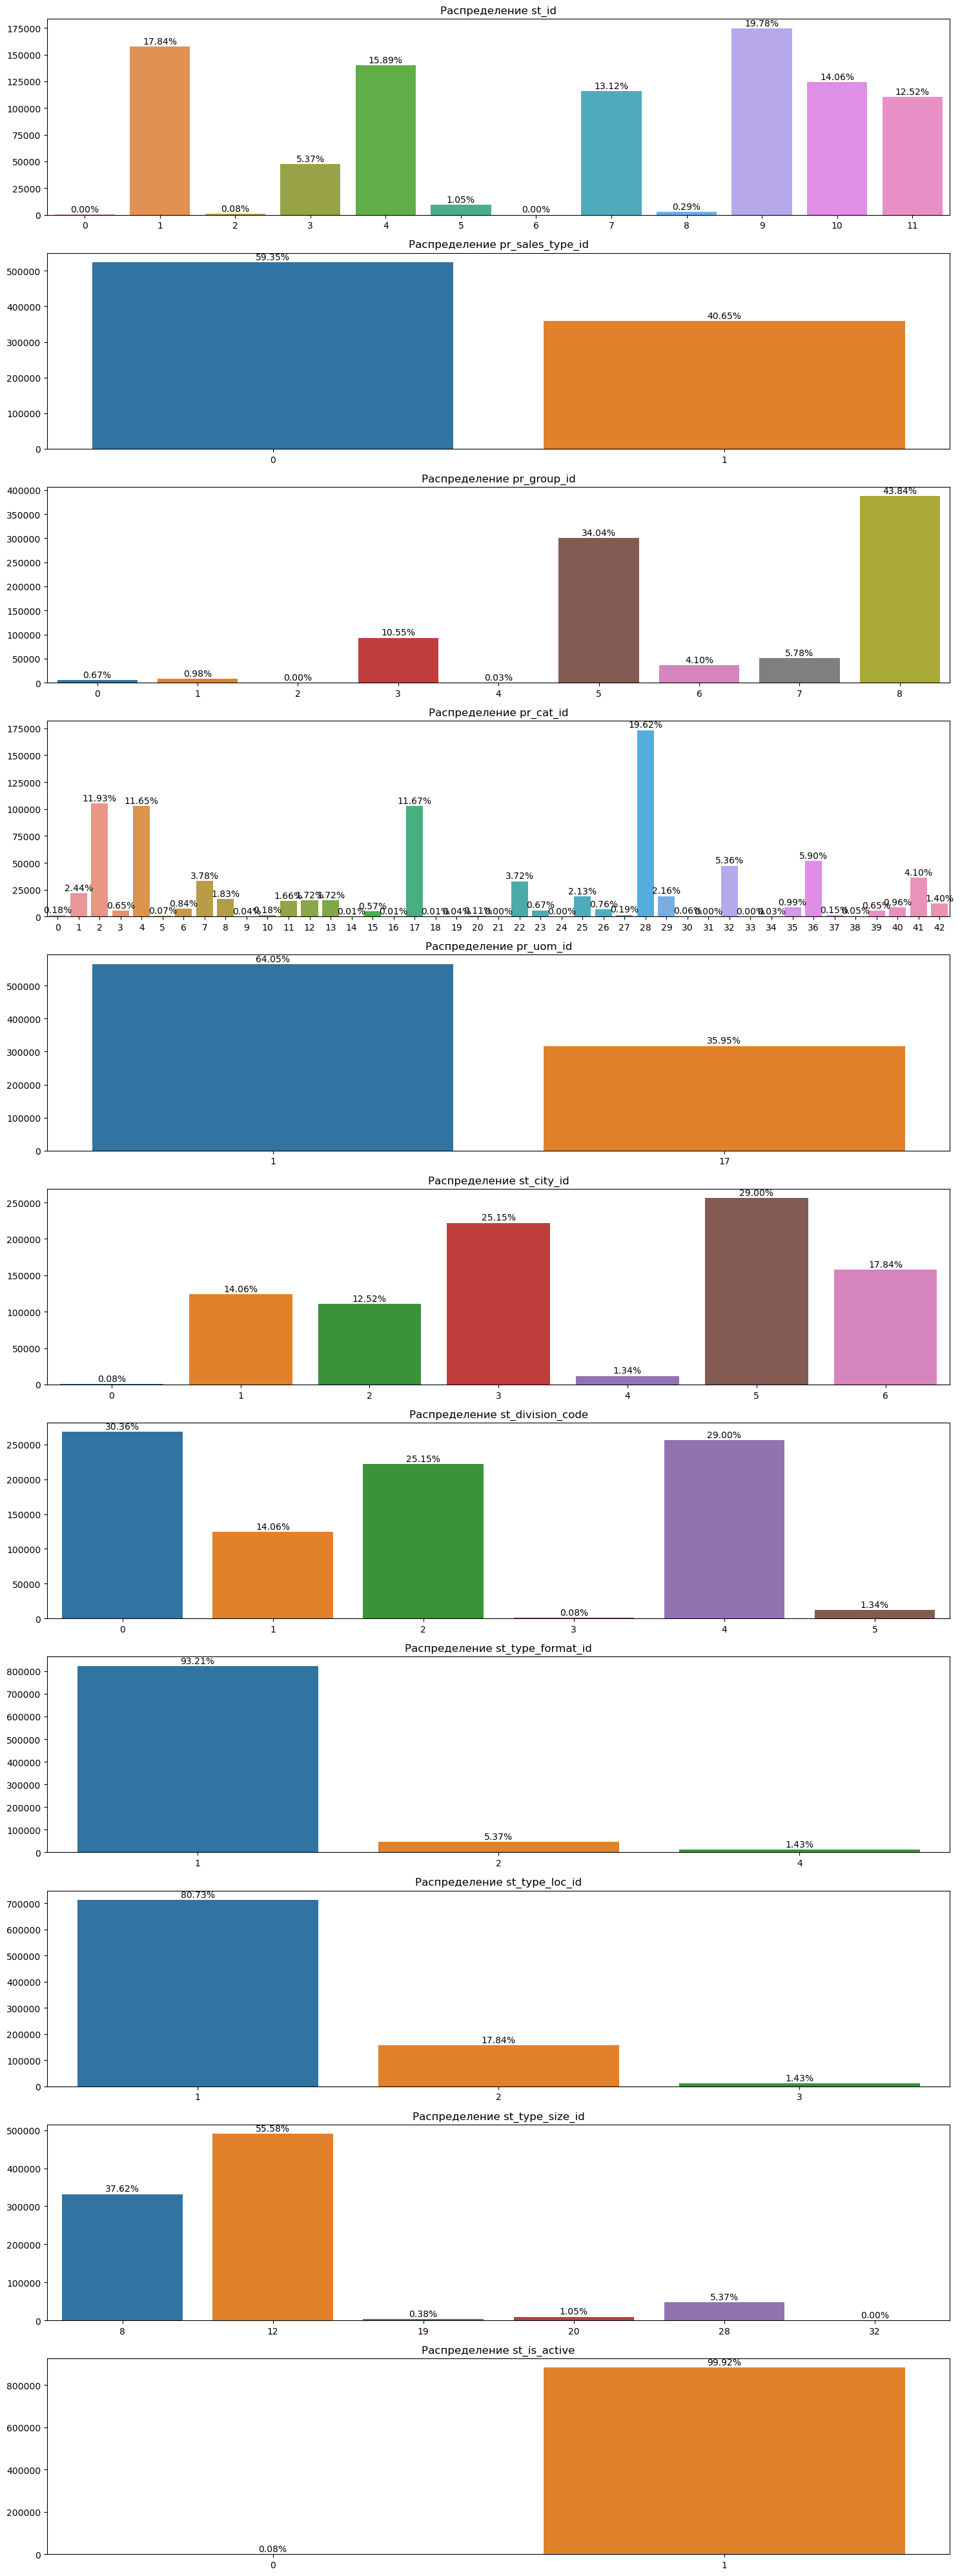

In [15]:
cols = 1
rows = len(cat_cols)
fig, axes = plt.subplots(rows, cols, figsize=(15, 40), dpi=100)

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=df_num, x=col, ax=ax)
    ax.set_title(f"Распределение {col}")
    ax.set(xlabel=None, ylabel=None)

    total = len(df_num)
    for p in ax.patches:
        percentage = f'{100 * p.get_height() / total:.2f}%\n'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.annotate(percentage, (x, y), ha='center', va='center')

plt.tight_layout()
plt.show()

In [16]:
# Создание среза таблицы для просмотра общих продаж в штуках во времени 
df_a = df[['date', 'pr_sales_in_units']]
df_a = set_date_index(df_a, 'date')
df_a = df_a.resample('1d').sum()

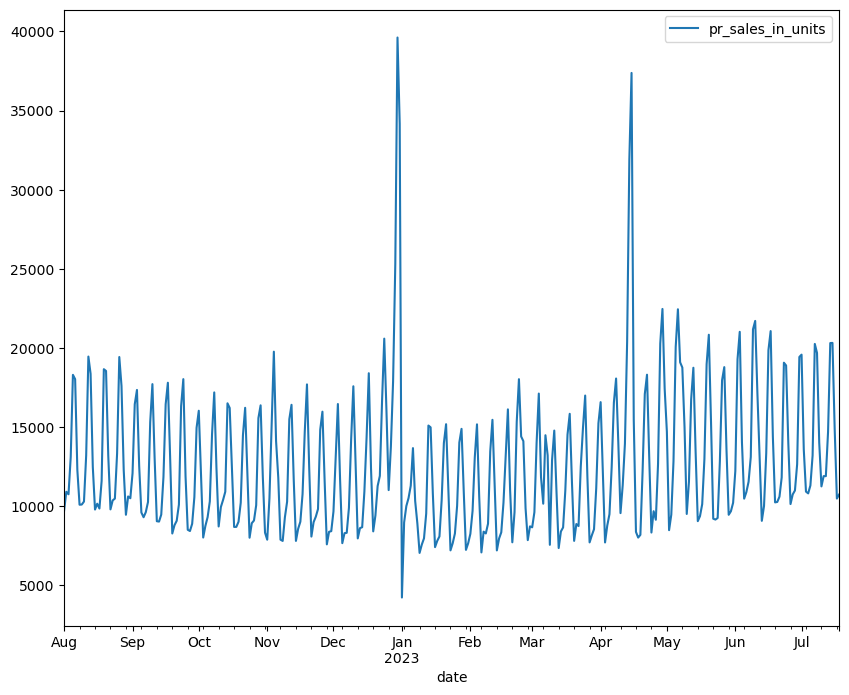

In [17]:
# Вывод графика распределения общих продаж
df_a.plot(figsize=(10, 8))
plt.show()

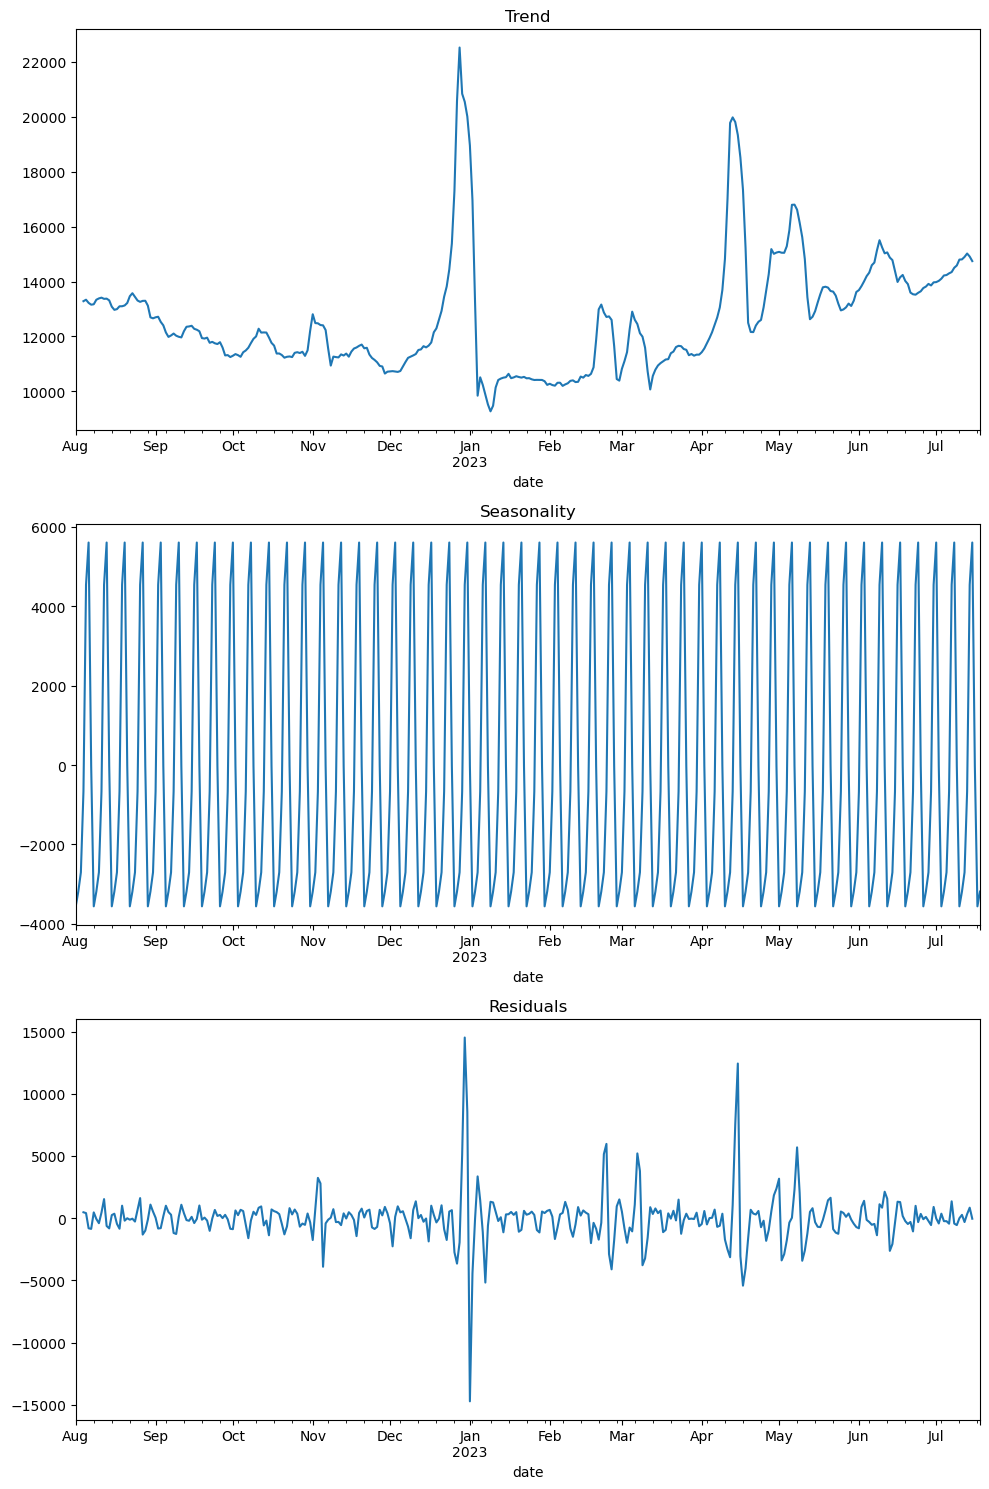

In [18]:
# Визуализация трендов,сезонности общих продаж во времени
decomposed = seasonal_decompose(df_a)

plt.figure(figsize=(10, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По полученным графикам видно, что в конце декабря имеется очень большой скачок продаж, а потом резкое падение. Такой подьем продаж можно объяснить тем, что происходит празднование Нового года. А вот падение приходится на начало января. Это может быть связано со списанием товаров с ограниченным сроком годности. В целом на графике с трендами видны всплески продаж в период праздников. Например,  в конце февраля - начале марта (23 февраля, 8 марта, масленица) или апрель - май (пасха, 1 мая, 9 мая). Самый низкий тред продаж на графике это январь-февраль, самый высокий декабрь.

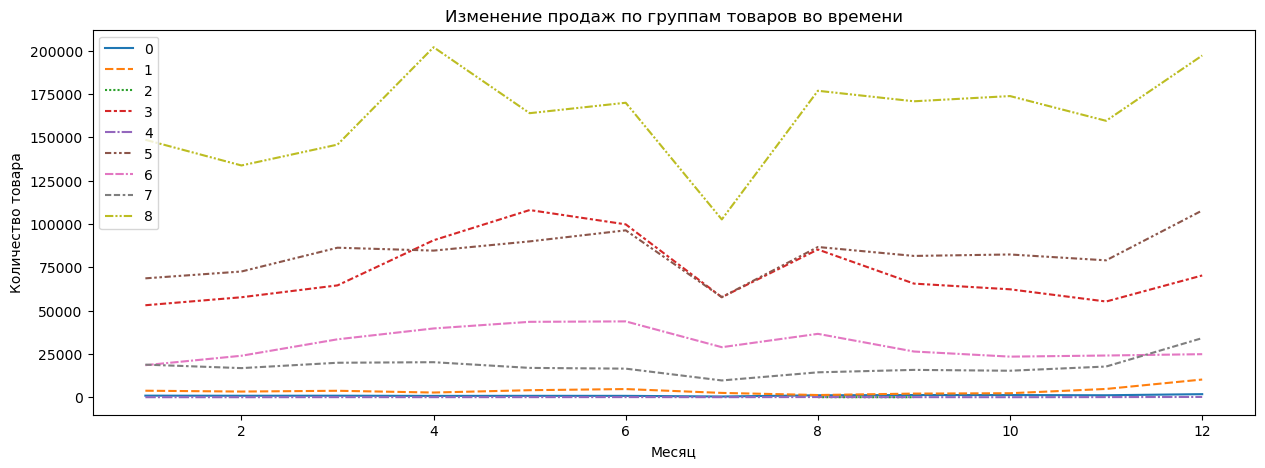

In [19]:
#  Визуализация распределения общих продаж каждой группы товаров во времени
df_plot = df_num[['date', 'pr_group_id', 'pr_sales_in_units']].copy()
df_plot = set_date_index(df_plot, 'date')
pivot_table = df_plot.pivot_table(index=df_plot.index.month, columns='pr_group_id', values='pr_sales_in_units', aggfunc='sum')


plt.figure(figsize=(15, 5))
sns.lineplot(data=pivot_table)

plt.legend(loc='upper left')
plt.xlabel('Месяц')
plt.ylabel('Количество товара')
plt.title('Изменение продаж по группам товаров во времени')

plt.show()

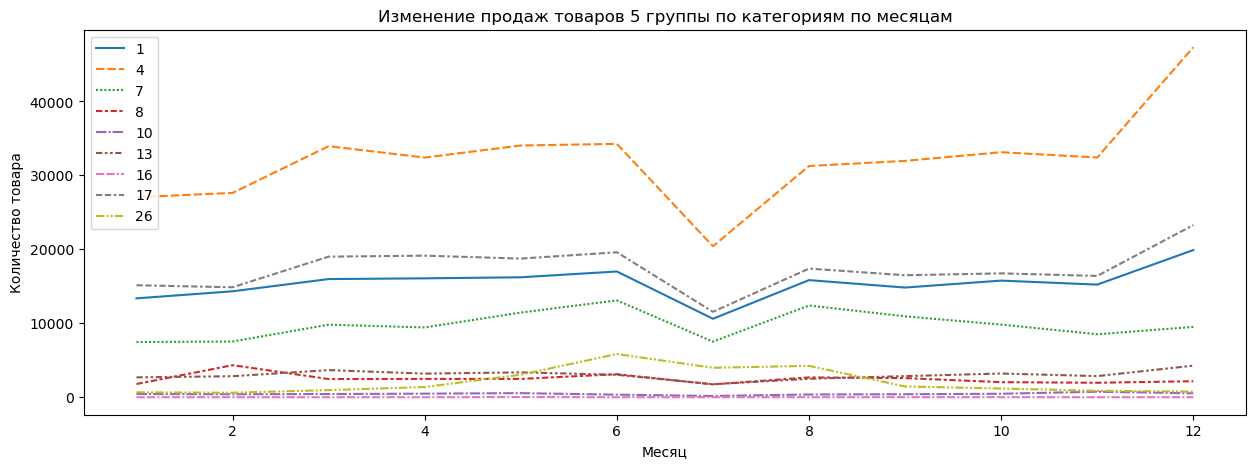

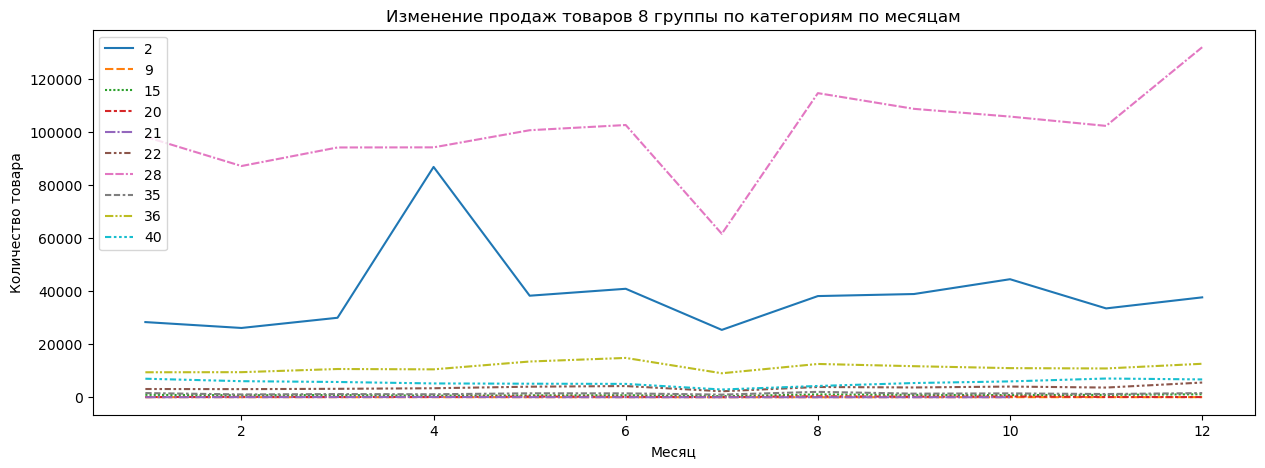

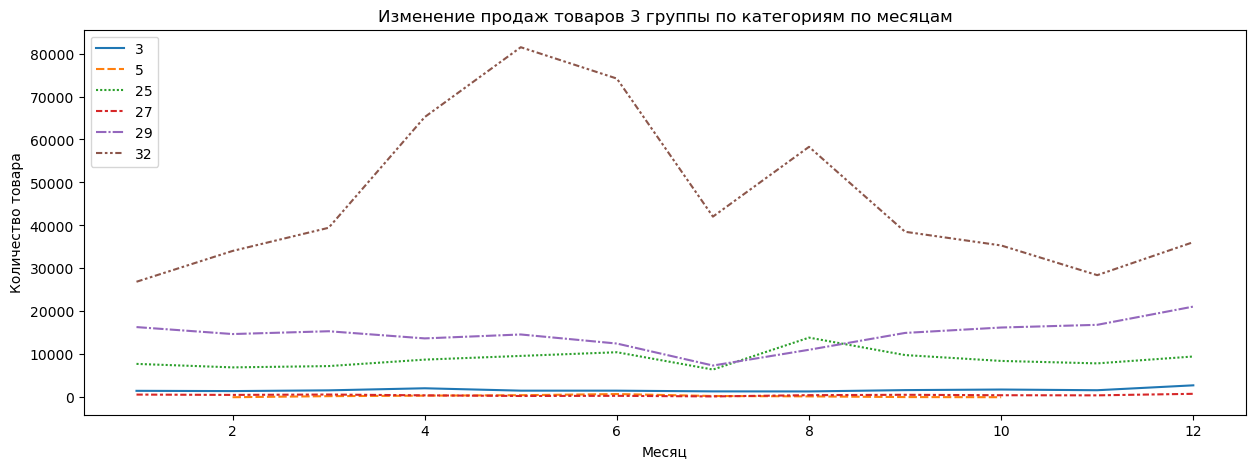

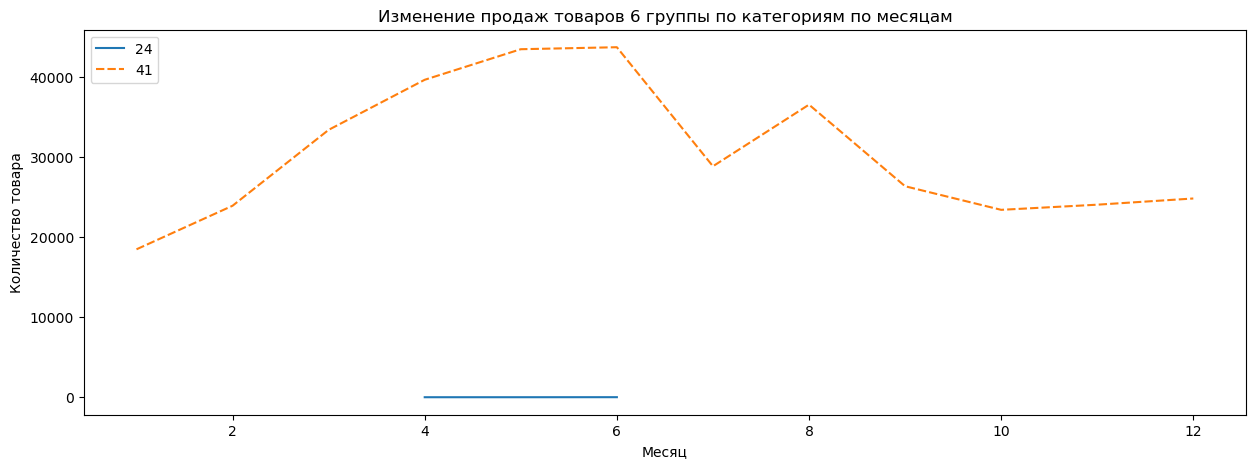

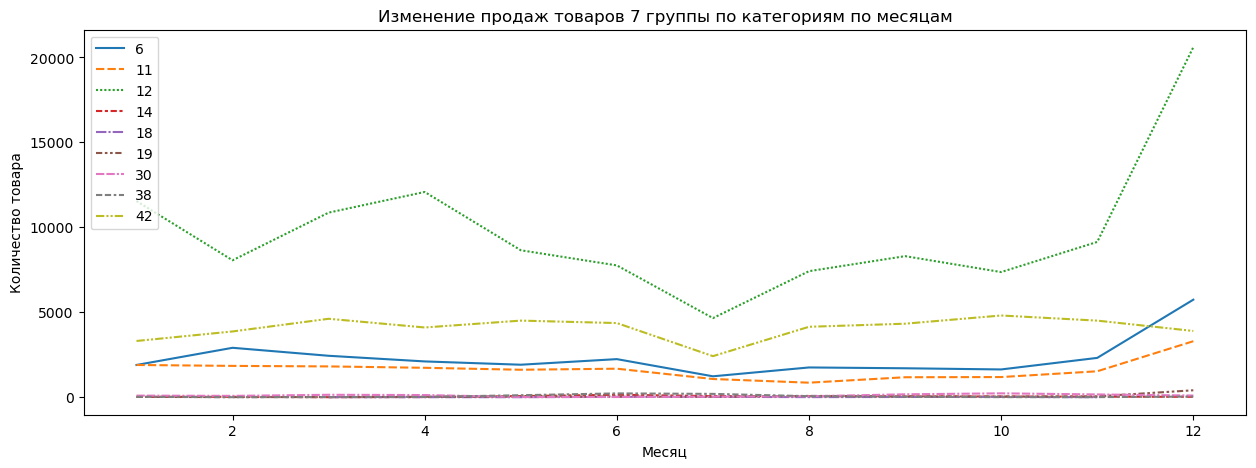

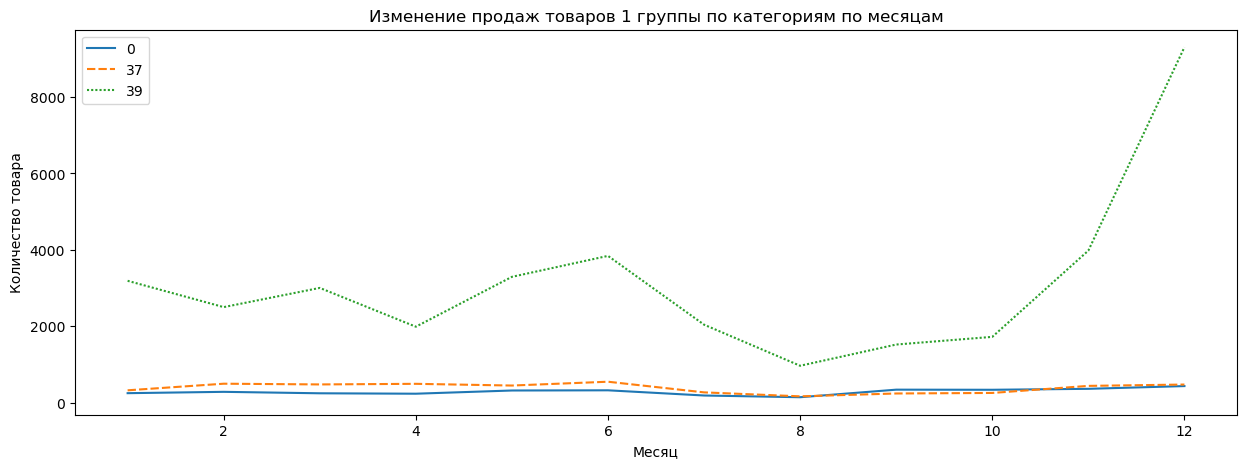

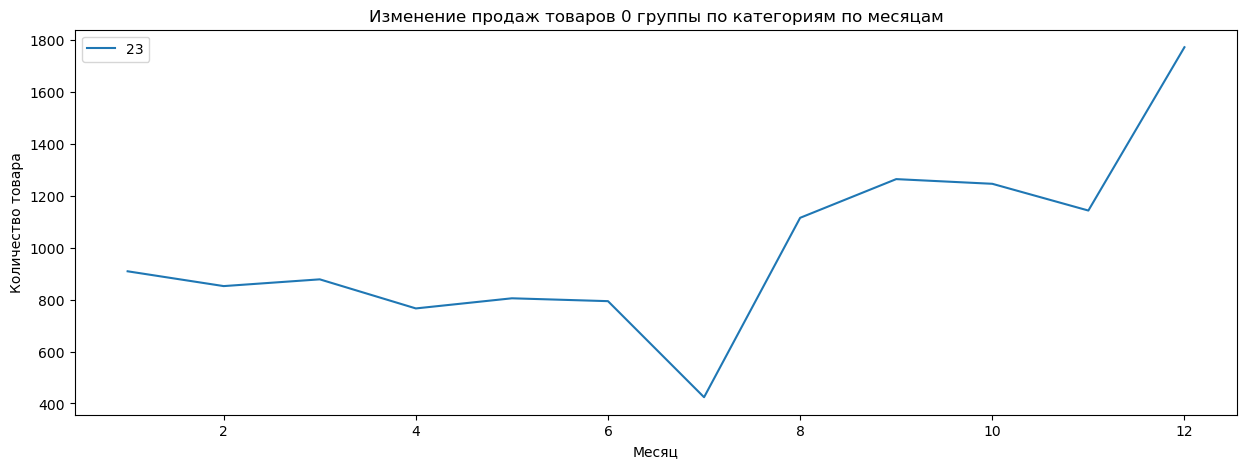

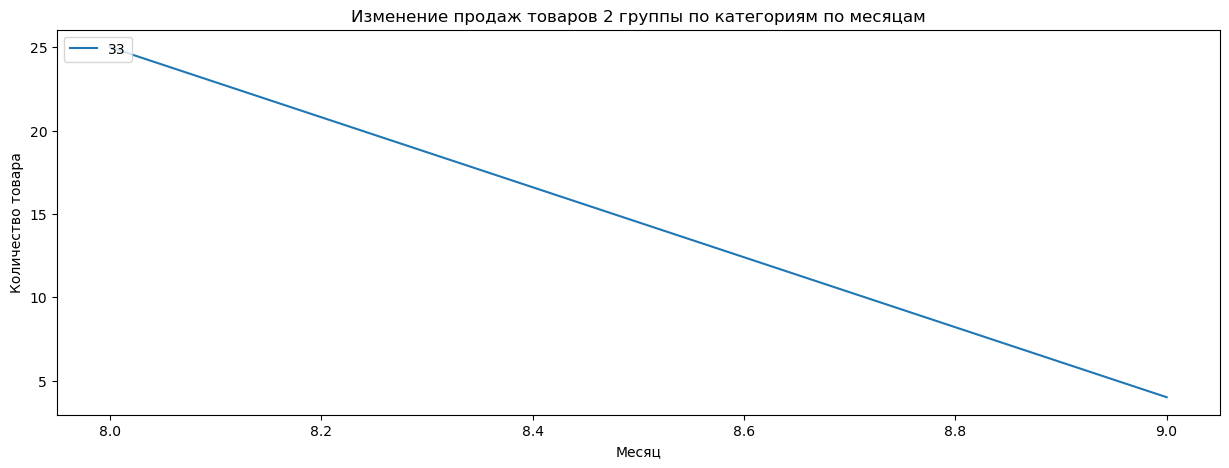

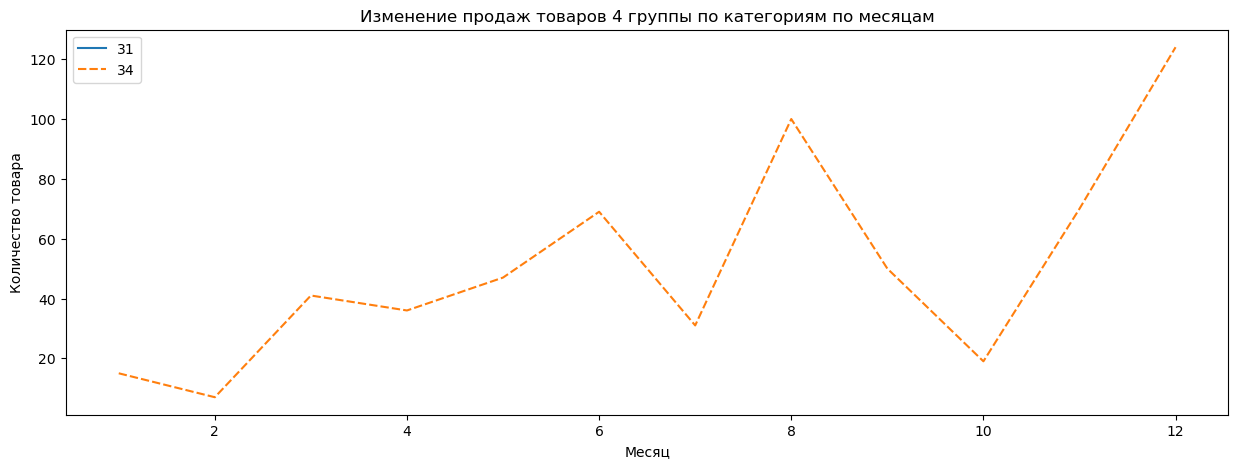

In [20]:
# Визуализация продаж категорий товаров внутри групп во времени
name_group_id = df_num['pr_group_id'].unique()

for name in name_group_id:
    plot_cat_sales(df_num, name,  'date', 'pr_group_id', 'pr_cat_id', 'pr_sales_in_units')
    

In [21]:
del df_plot
del pivot_table
del df_a
del df
del train
del pr
del st_df

In [22]:
df_num = df_num.query('pr_promo_sales_in_units > 0 & st_is_active != 0')

# Feature engineering

**Создание дополнительных лаговых и временных признаков**
* pr_sales_in_units_lag - общие продажи за 7 дней в штуках с группировкой по категориям товаров.
* pr_sales_in_rub_lag - общие продажи за 7 дней в рублях с группировкой по категориям товаров..
* pr_sales_in_units_max_lag - максисмальная сумма продаж в штуках за 7 дней с группировкой по категориям товаров.
* pr_sales_in_units_min_lag - минимальная сумма продаж в штуках за 7 дней с группировкой по категориям товаров.
* pr_sales_in_rub_max_lag - максисмальная сумма продаж в рублях за 7 дней с группировкой по категориям товаров.
* pr_sales_in_rub_min_lag - минимальная сумма продаж в рублях за 7 дней с группировкой по категориям товаров.
* mean sales_week_lag - среднее значение продаж за последние 7 дней для каждой группы.
* lag_feature_weekday - день недели.
* month - месяц.
* quarter - квартал.
* lag_feature_4weeks - продажи за 4 недели без группировок
* lag_feature_1week - продажи за 1 неделю без группировки.
* sales_ratio - отношения продаж за 4 недели к продажам за последнюю неделю.
* sales_ratio_cat - отношения продаж товара к продажам во всей категории.
* sales_slope - угловой коэффициент графика продаж товара за последние 7 дней


In [23]:
df_num = df_num.sort_values('date', ascending=False)\
    .assign(pr_sales_in_units_lag=df_num.groupby('pr_cat_id')['pr_sales_in_units'].shift(7),
            pr_sales_in_rub_lag=df_num.groupby('pr_cat_id')['pr_sales_in_rub'].shift(7),
            pr_sales_in_units_max_lag=df_num.groupby('pr_cat_id')['pr_sales_in_units'].transform(lambda x: x.rolling(window=7).max()),
            pr_sales_in_units_min_lag=df_num.groupby('pr_cat_id')['pr_sales_in_units'].transform(lambda x: x.rolling(window=7).min()),
            pr_sales_in_rub_max_lag=df_num.groupby('pr_cat_id')['pr_sales_in_rub'].transform(lambda x: x.rolling(window=7).max()),
            pr_sales_in_rub_min_lag=df_num.groupby('pr_cat_id')['pr_sales_in_rub'].transform(lambda x: x.rolling(window=7).min()),
            mean_sales_week_lag=df_num.groupby(['pr_cat_id', 'pr_sku_id'])['pr_sales_in_units'].transform(lambda x: x.rolling(window=14).mean()),
            lag_feature_weekday=df_num['date'].dt.weekday.shift(1),
            month=df_num['date'].dt.month,
            quarter=df_num['date'].dt.quarter,
            lag_feature_4weeks=df_num['pr_sales_in_units'].rolling(window=28).sum(),
            lag_feature_1week=df_num['pr_sales_in_units'].rolling(window=7).sum(),
            sales_ratio=lambda x: x['lag_feature_4weeks'] / x['lag_feature_1week'],
            sales_ratio_cat=df_num['pr_sales_in_units'] / df_num.groupby('pr_cat_id')['pr_sales_in_units'].transform('sum'), 
            lag_dayofyear = df_num['date'].dt.dayofyear)

In [24]:
correlation = df_num.corr()['pr_sales_in_units']

# Выводим корреляцию для каждого признака
print(correlation)

st_id                        0.006464
pr_sku_id                   -0.042240
date                         0.026032
pr_sales_type_id                  NaN
pr_sales_in_units            1.000000
pr_promo_sales_in_units      1.000000
pr_sales_in_rub              0.713817
pr_promo_sales_in_rub        0.713817
pr_group_id                 -0.107736
pr_cat_id                    0.097473
pr_subcat_id                 0.004922
pr_uom_id                   -0.059875
st_city_id                   0.005681
st_division_code            -0.017213
st_type_format_id           -0.053447
st_type_loc_id              -0.005088
st_type_size_id             -0.050738
st_is_active                      NaN
pr_sales_in_units_lag        0.230029
pr_sales_in_rub_lag          0.196864
pr_sales_in_units_max_lag    0.562716
pr_sales_in_units_min_lag    0.329783
pr_sales_in_rub_max_lag      0.411119
pr_sales_in_rub_min_lag      0.207792
mean_sales_week_lag          0.560258
lag_feature_weekday         -0.003701
month       

In [25]:
pd.set_option('display.max_columns', None)
df_num.head(10)

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub,pr_group_id,pr_cat_id,pr_subcat_id,pr_uom_id,st_city_id,st_division_code,st_type_format_id,st_type_loc_id,st_type_size_id,st_is_active,pr_sales_in_units_lag,pr_sales_in_rub_lag,pr_sales_in_units_max_lag,pr_sales_in_units_min_lag,pr_sales_in_rub_max_lag,pr_sales_in_rub_min_lag,mean_sales_week_lag,lag_feature_weekday,month,quarter,lag_feature_4weeks,lag_feature_1week,sales_ratio,sales_ratio_cat,lag_dayofyear
227621,7,1246,2023-07-18,1,9.0,9.0,2403.0,2403.0,3,29,10,1,5,4,1,1,12,1,7.0,1930.0,10.0,1.0,2580.0,258.0,5.571429,4.0,7,3,162.0,35.0,4.628571,0.000074,199
291643,1,242,2023-07-18,1,3.0,3.0,206.0,206.0,8,36,58,17,6,0,1,2,8,1,25.0,1603.0,32.0,3.0,2038.0,196.0,14.071429,1.0,7,3,333.0,99.0,3.363636,0.000047,199
766291,4,696,2023-07-18,1,1.0,1.0,79.0,79.0,5,17,69,1,5,4,1,1,12,1,5.0,412.0,5.0,1.0,448.0,58.0,2.214286,4.0,7,3,54.0,17.0,3.176471,0.000016,199
9349,9,1981,2023-07-18,1,14.0,14.0,1821.0,1821.0,5,4,125,1,3,2,1,1,8,1,6.0,904.0,23.0,1.0,3068.0,111.0,7.500000,4.0,7,3,280.0,64.0,4.375000,0.000098,199
242331,7,863,2023-07-18,1,28.0,28.0,1773.0,1773.0,8,28,152,17,5,4,1,1,12,1,58.0,3384.0,66.0,2.0,4150.0,114.0,25.428571,6.0,7,3,829.0,195.0,4.251282,0.000091,199
819450,4,48,2023-07-18,1,1.0,1.0,257.0,257.0,5,4,75,1,5,4,1,1,12,1,2.0,671.0,1.0,1.0,369.0,179.0,1.071429,0.0,7,3,44.0,7.0,6.285714,0.000007,199
259025,7,1668,2023-07-18,1,2.0,2.0,534.0,534.0,5,17,133,1,5,4,1,1,12,1,1.0,147.0,7.0,1.0,1524.0,204.0,2.214286,2.0,7,3,76.0,20.0,3.800000,0.000032,199
854632,3,405,2023-07-18,1,1.0,1.0,43.0,43.0,8,28,152,17,3,2,2,1,28,1,2.0,145.0,4.0,1.0,167.0,43.0,2.142857,5.0,7,3,62.0,16.0,3.875000,0.000003,199
153585,9,226,2023-07-18,1,2.0,2.0,85.0,85.0,5,17,49,17,3,2,1,1,8,1,1.0,28.0,15.0,2.0,637.0,85.0,NaN,2.0,7,3,65.0,39.0,1.666667,0.000032,199
394516,1,1574,2023-07-18,1,5.0,5.0,159.0,159.0,5,26,114,1,6,0,1,2,8,1,7.0,207.0,6.0,2.0,180.0,52.0,4.857143,4.0,7,3,238.0,21.0,11.333333,0.000715,199


In [26]:
len(df_num)

327442

# Обучение 

In [27]:
df_num.sort_values(by='date',inplace=True)
df_num = df_num.set_index('date')
df_num= df_num.dropna()
len(df_num)

307682

In [28]:
train, test = train_test_split(df_num, shuffle=False, test_size=.1)
train, valid = train_test_split(train, shuffle=False, test_size=.33)

print("Размер обучающей выборки: {:.0%}".format(train.shape[0] / df_num.shape[0]))
print("Размер валидационной выборки: {:.0%}".format(valid.shape[0] / df_num.shape[0]))
print("Размер тестовой выборки: {:.0%}".format(test.shape[0] / df_num.shape[0]))

Размер обучающей выборки: 60%
Размер валидационной выборки: 30%
Размер тестовой выборки: 10%


In [29]:
features_test = test.drop(['pr_sales_in_units'], axis=1)
target_test = test['pr_sales_in_units']

features_valid = valid.drop(['pr_sales_in_units'], axis=1)
target_valid = valid['pr_sales_in_units']

features_train = train.drop(['pr_sales_in_units'], axis=1)
target_train = train['pr_sales_in_units']

In [30]:
scaler = StandardScaler()

In [31]:
features_train = scaler.fit_transform(features_train)
features_valid = scaler.transform(features_valid)
features_test = scaler.transform(features_test)

In [32]:
tscv = TimeSeriesSplit(n_splits = 3) 

In [33]:
# Парметры моделей и pipeline
linear_params = {
    'linear__fit_intercept': [True, False],
    'linear__copy_X': [True, False],
    'linear__n_jobs': [1, -1],
    'linear__positive': [True, False]
}

svm_params = {
    'svm__C': [1.0, 2.0, 5.0],  
    'svm__epsilon': [0.1, 0.2, 0.3]
}

xgb_params = {
    'xgb__learning_rate': [0.1, 0.01, 0.001], 
    'xgb__max_depth': [3, 5, 7], 
}


rf_params = {
    'rf__n_estimators': range(300, 500, 25),
    'rf__min_samples_split': [2, 3, 4, 5, 6, 7],
}


linear_pipeline = Pipeline([('linear', LinearRegression())])

svm_pipeline = Pipeline([('svm', SVR())])

xgb_pipeline = Pipeline([('xgb', XGBRegressor())])

rf_pipeline = Pipeline([('rf', RandomForestRegressor())])


# Создание метрики WAPE в качестве scorer
scorer = make_scorer(rolling_wape, greater_is_better=False)


# Создание списков моделей и их параметров, которые будут использоваться на каждом уровне
models_1st_level = [linear_pipeline, svm_pipeline, xgb_pipeline, rf_pipeline]
params_1st_level = [linear_params, svm_params, xgb_params, rf_params]

In [34]:
est_meta = pd.DataFrame(target_valid)
all_models = []
batch_size = 10000 
grid_features = features_train[:batch_size]
grid_target = target_train[:batch_size]
with tqdm(total=len(features_train)) as pbar:
    for model, params in tqdm(zip(models_1st_level, params_1st_level), total=len(models_1st_level), desc='1st Level Models'):
        grid_search = GridSearchCV(model, params, scoring=scorer, cv=tscv)
        grid_search.fit(grid_features, grid_target)
        best_model = grid_search.best_estimator_
        all_models.append(best_model)
        for i in range(0, len(features_train), batch_size):
            X_batch = features_train[i:i+batch_size]
            y_batch = target_train[i:i+batch_size]
            best_model.fit(X_batch, y_batch)
            pbar.update(batch_size)
        predictions = best_model.predict(features_valid)
        est_meta[model] = predictions     
        print(f"WAPE for {list(model.named_steps.keys())[0]}: {rolling_wape(target_valid, predictions)}")

1st Level Models:  25%|████████████████▌                                                 | 1/4 [00:00<00:01,  2.59it/s]

WAPE for linear: 1.626952235413859e-15


380000it [02:10, 3485.08it/s]                                                                                          
1st Level Models:  50%|█████████████████████████████████                                 | 2/4 [02:13<02:36, 78.34s/it]

WAPE for svm: 0.3180171681582887


570000it [02:18, 68640.38it/s]
1st Level Models:  75%|█████████████████████████████████████████████████▌                | 3/4 [02:18<00:44, 44.97s/it]

WAPE for xgb: 0.04739005076842793


760000it [36:35, 471.64it/s]  
1st Level Models: 100%|█████████████████████████████████████████████████████████████████| 4/4 [36:37<00:00, 549.31s/it]
760000it [36:37, 345.89it/s]

WAPE for rf: 0.055438167077937694


In [35]:
features_meta = est_meta.drop(['pr_sales_in_units'], axis=1)
target_meta = est_meta['pr_sales_in_units']

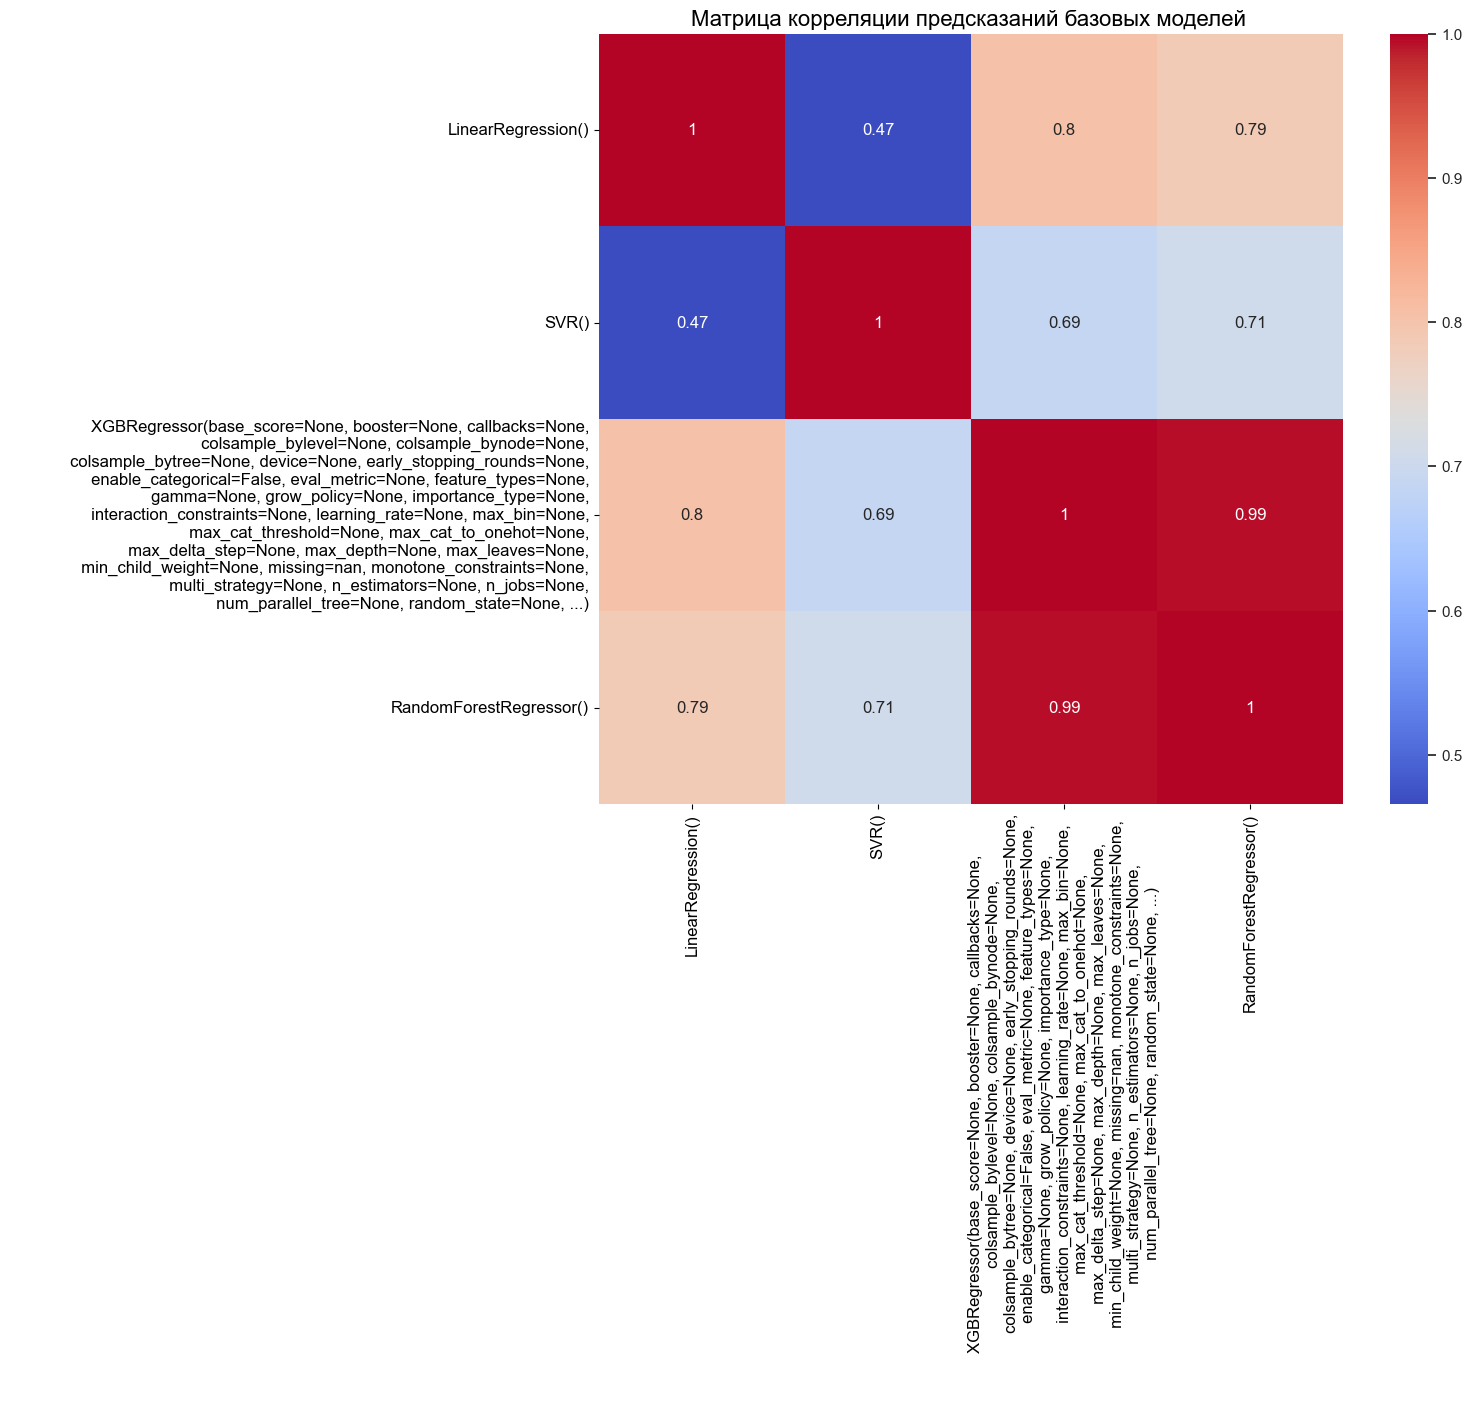

In [36]:
# Generate correlation matrix
fig, ax = plt.subplots(figsize=(12, 10))

sns.set(font_scale=1.0)
sns.heatmap(features_meta.corr(), annot=True, cmap='coolwarm', ax=ax)
ax.set_title("Матрица корреляции предсказаний базовых моделей ", fontsize=16)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=12)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=12)
plt.show()

In [37]:
meta = GradientBoostingRegressor()

In [38]:
meta.fit(features_meta, target_meta)

GradientBoostingRegressor()

In [39]:
all_models

[Pipeline(steps=[('linear', LinearRegression(n_jobs=1))]),
 Pipeline(steps=[('svm', SVR(C=5.0))]),
 Pipeline(steps=[('xgb',
                  XGBRegressor(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               m

In [40]:
meta_dict = {
    'LinearRegression': all_models[0],
    'SVR': all_models[1], 
    'XGBRegressor': all_models[2],
    'RandomForestRegressor': all_models[3]
}

In [41]:
meta_dict

{'LinearRegression': Pipeline(steps=[('linear', LinearRegression(n_jobs=1))]),
 'SVR': Pipeline(steps=[('svm', SVR(C=5.0))]),
 'XGBRegressor': Pipeline(steps=[('xgb',
                  XGBRegressor(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, mi

# Анализ оценок

In [42]:
def meta_scoring(features, target, meta, meta_dict, test):

    test_scores = []
    
    df_pred = pd.DataFrame(columns=meta_dict.keys()) 
    
    
    for key, reg in meta_dict.items():
        
        pred_y = reg.predict(features)
        df_pred[key] = pd.Series(pred_y).transpose()
        
        test_scores.append(rolling_wape(target, pred_y)*100)
        
    results = pd.DataFrame({'Model': list(meta_dict.keys()), 
                            'WAPE': test_scores,
                            })

    df_pred['Meta_Model'] = meta.predict(df_pred) 
    
    s1 = round(rolling_wape(target, df_pred['Meta_Model'].values), 4)


    df_pred['pr_sales_in_units'] = target.tolist()
    df_pred['st_id'] = test['st_id'].tolist()
    df_pred['pr_sku_id'] = test['pr_sku_id'].tolist()
        
        
    row1 = ['Meta_Model', s1]
    results.loc[len(results)] = row1
    
    return results, df_pred

In [43]:
scores, df_pred = meta_scoring(features_test, target_test, meta, meta_dict, test)

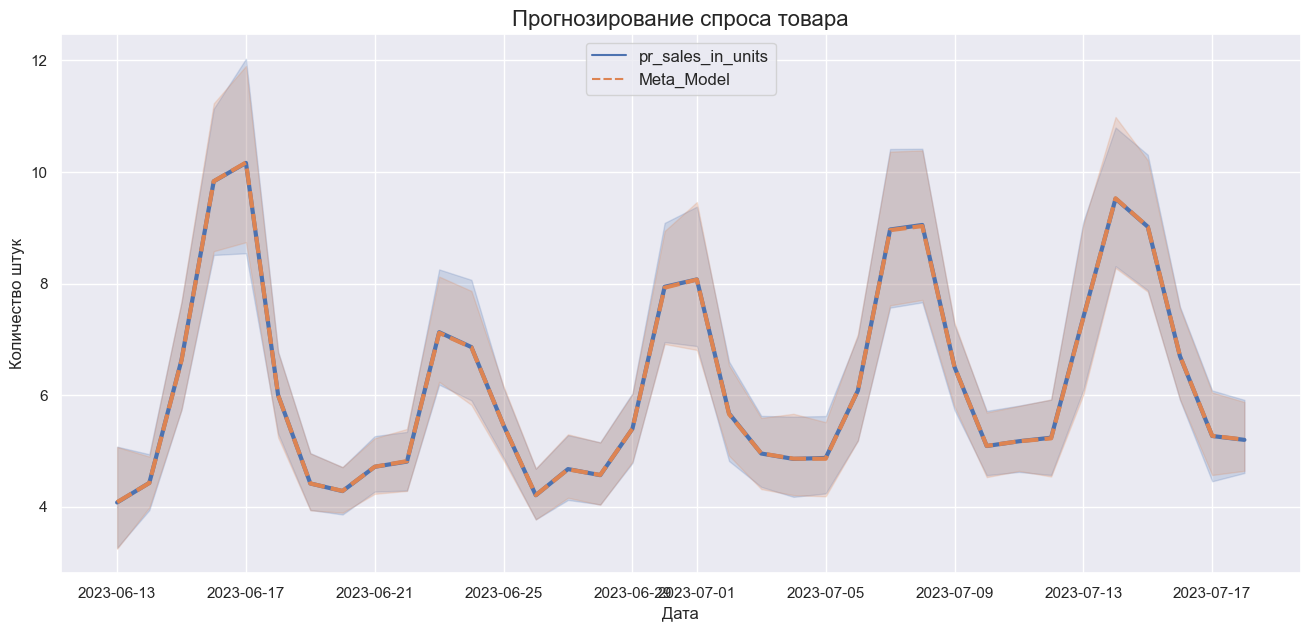

In [44]:
df_pred.index = test.index

# Model predictions on test holdout data
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['pr_sales_in_units', 'Meta_Model']], ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Прогнозирование спроса товара', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Количество штук', fontsize=12);

In [45]:
df_pred.to_csv("predict_sales.csv")